In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pickle
import os

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive/", force_remount=True)
# %cd /content/drive/MyDrive/project_eeg/

In [ ]:
import utils
import models

In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_test = np.load("person_test.npy")

X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_train_valid = np.load("person_train_valid.npy")

In [ ]:
# adjusting the labels
y_train_valid -= 769
y_test -= 769

# split into train and validation sets
X_train, y_train, X_val, y_val = utils.train_val_split(X_train_valid, y_train_valid)

# CNN

In [ ]:
# don't run this twice !
X_train,  y_train  = utils.augment_reshape(X_train, y_train)
X_val,    y_val    = utils.augment_reshape(X_val,   y_val)
X_test,   y_test   = utils.augment_reshape(X_test,  y_test)

In [ ]:
model = models.cnn()
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
ret = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val), verbose=False)

In [ ]:
print('Train accuracy = ', utils.max_vote(model, X_train, y_train))
print('Validation accuracy = ', utils.max_vote(model, X_val, y_val))
print('Test accuracy = ', utils.max_vote(model, X_test, y_test))

# CNN-LSTM

In [ ]:
# don't run this twice ! (skip if already run for the CNN)
X_train,  y_train  = utils.augment_reshape(X_train, y_train)
X_val,    y_val    = utils.augment_reshape(X_val,   y_val)
X_test,   y_test   = utils.augment_reshape(X_test,  y_test)

In [ ]:
model = models.cnn_lstm()
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),metrics=['accuracy'])
ret = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val), verbose=False)

In [ ]:
print('Train accuracy = ', utils.max_vote(model, X_train, y_train))
print('Validation accuracy = ', utils.max_vote(model, X_val, y_val))
print('Test accuracy = ', utils.max_vote(model, X_test, y_test))

# SkipNet

In [ ]:
# Generate spectrograms images from EEG signals, load from pickle if available as it is time taking
(X_train, y_train, X_val, y_val, X_test, y_test) = utils.eeg_to_spectrum(X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
model = models.skipnet()
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
ret = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose=False)

In [ ]:
utils.max_vote(model, X_train, y_train)
utils.max_vote(model, X_val, y_val)
utils.max_vote(model, X_test, y_test)

In [ ]:
# Generate Augmented Adversarial Samples
if os.path.isfile('skipnet_gen.pickle'):
  with open('skipnet_gen.pickle', 'rb') as f:
    (X_new, y_new) = pickle.load(f)
else:
  corr_idx = utils.max_vote(model, X_train, y_train, ret_corr=True)
  X_new, y_new = utils.generate_samples(X_train[corr_idx], y_train[corr_idx], model, eps=0.001)
  with open('skipnet_gen.pickle', 'wb') as f:
    pickle.dump((X_new, y_new), f)

In [ ]:
print("Before:\n"+"="*20)
utils.max_vote(model, X_train, y_train)
utils.max_vote(model, X_val, y_val)
utils.max_vote(model, X_test, y_test)
utils.max_vote(model, X_new, y_new)

X_train_new = np.vstack((X_train, X_new[::40]))
y_train_new = np.vstack((y_train, y_new[::40]))
ret = model.fit(X_train_new, y_train_new, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose=False)

print("\nAfter:\n"+"="*20)
utils.max_vote(model, X_train, y_train)
utils.max_vote(model, X_val, y_val)
utils.max_vote(model, X_test, y_test)
utils.max_vote(model, X_new, y_new)

# Miscellaneous

### Tests and Experiments

In [ ]:
# without preprocessing the individual subjects data , we were able to obtain better test accuracy for subject 1

def train_data(sub_idx=None, time_period=1000):
    # different period of time
    X_train_valid_cur = X_train_valid[:, :, :time_period]
    y_train_valid_cur = y_train_valid
    X_test_cur = X_test[:, :, :time_period]
    y_test_cur = y_test
    
    # single subject dataset
    if sub_idx is not None:
        X_train_valid_cur = X_train_valid_cur[np.where(person_train_valid == sub_idx)[0]]
        y_train_valid_cur = y_train_valid[np.where(person_train_valid == sub_idx)[0]]
        X_test_cur = X_test_cur[np.where(person_test == sub_idx)[0]]
        y_test_cur = y_test[np.where(person_test == sub_idx)[0]]

    # preprocess data
    X_train_valid_cur = np.expand_dims(X_train_valid_cur, axis=3)
    X_test_cur = np.expand_dims(X_test_cur, axis=3)
    lecun = lecun_uniform(seed=42)
    

    model = CNN_LSTM(lecun, time_period)
    model.fit(X_train_valid_cur, y_train_valid_cur, epochs=40, batch_size=32, validation_data=(X_test_cur, y_test_cur), shuffle=True, verbose=1)
    train_score = model.evaluate(X_train_valid_cur, y_train_valid_cur)
    test_score = model.evaluate(X_test_cur, y_test_cur)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    print(model.summary())
    
    return train_score, test_score

## **Testing for 1000 time steps: Subject Wise Training using the hybrid CNN-LSTM model optimized for subject 1**

In [ ]:
single_train_scores = []
single_test_scores = []
for i in range(9):
    train_score, test_score = train_data(sub_idx=i)
    single_train_scores.append(train_score[1])
    single_test_scores.append(test_score[1])

print("Single train accuracies: ")
print(single_train_scores)
print("Single test accuracies: ")
print(single_test_scores)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 19s 310ms/step - loss: 3.0173 - categorical_accuracy: 0.1814 - val_loss: 2.8919 - val_categorical_accuracy: 0.2400
Epoch 2/40
8/8 [==============================] - 0s 27ms/step - loss: 2.8350 - categorical_accuracy: 0.2574 - val_loss: 2.7555 - val_categorical_accuracy: 0.2400
Epoch 3/40
8/8 [==============================] - 0s 27ms/step - loss: 2.6915 - categorical_accuracy: 0.2447 - val_loss: 2.6906 - val_categorical_accuracy: 0.2400
Epoch 4/40
8/8 [==============================] - 0s 27ms/step - loss: 2.5296 - categorical_accuracy: 0.3080 - val_loss: 2.5817 - val_categorical_accuracy: 0.2400
Epoch 5/40
8/8 [==============================] - 0s 27ms/step - loss: 2.3925 - categorical_accuracy: 0.3207 - val_loss: 2.6609 - val_categorical_accuracy: 0.2400
Epoch 6/40
8/8 [==============================] - 0s 27ms/step - loss: 2.1581 - categorical_accuracy: 0.4684 - val_loss: 2.6396 - val_categorical_accuracy: 0.2400
Epoch 7/40
8/8 [===============

## **Testing for 500 time steps : individual subject test accuracies **

In [ ]:
single_train_scores = []
single_test_scores = []
for i in range(9):
    train_score, test_score = train_data(sub_idx=i, time_period = 500)
    single_train_scores.append(train_score[1])
    single_test_scores.append(test_score[1])

print("Single train accuracies: ")
print(single_train_scores)
print("Single test accuracies: ")
print(single_test_scores)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 10s 315ms/step - loss: 2.9203 - categorical_accuracy: 0.2405 - val_loss: 2.8055 - val_categorical_accuracy: 0.2800
Epoch 2/40
8/8 [==============================] - 0s 18ms/step - loss: 2.7237 - categorical_accuracy: 0.3122 - val_loss: 2.6118 - val_categorical_accuracy: 0.3800
Epoch 3/40
8/8 [==============================] - 0s 19ms/step - loss: 2.5483 - categorical_accuracy: 0.2954 - val_loss: 2.4684 - val_categorical_accuracy: 0.2600
Epoch 4/40
8/8 [==============================] - 0s 18ms/step - loss: 2.4022 - categorical_accuracy: 0.2869 - val_loss: 2.2967 - val_categorical_accuracy: 0.3000
Epoch 5/40
8/8 [==============================] - 0s 18ms/step - loss: 2.2443 - categorical_accuracy: 0.3038 - val_loss: 2.1996 - val_categorical_accuracy: 0.3000
Epoch 6/40
8/8 [==============================] - 0s 19ms/step - loss: 2.0997 - categorical_accuracy: 0.3840 - val_loss: 2.2069 - val_categorical_accuracy: 0.2400
Epoch 7/40
8/8 [===============

## With preprocessing and data augmentation : Using the CNN - LSTM model optimized for all subjects together to see its efficacy for individual subject training and evaluation

In [ ]:
def max_vote(model, X, y, n_augmented=4):
    y_pred = model.predict(X)
    N = np.shape(X)[0]
    count = 0
    for i in range(N//n_augmented):
        pred = np.zeros(n_augmented)
        for j in range(n_augmented):
          pred[np.argmax(y_pred[i + (N//n_augmented)*j])] += 1
        if np.argmax(pred) == np.argmax(y[i]): count+=1
    accuracy = count/(N//n_augmented)
    return accuracy

In [ ]:
def train_and_evaluate(model, sub_train_idx, sub_test_idx):
  

  """

  Training and validating the model (CNN + LSTM : epochs - 50, batch_size - 64, learning rate - 5 * 10 ^(-4) , optimizer - Adam, lstm_units -20 ) 
  on the sub_train_idx 
  and Testing / Evaluating the trained model on sub_test_idx

  This function returns the test_accuracy for the model trained on sub_train_idx and evaluated on sub_test_idx (sub_test_idx can be equal to sub_train_idx)

  returns (test_acc)

  """
  # loading the train_val_set for sub_train_idx

  X_train_valid_sub_train = np.load("/content/drive/MyDrive/project_eeg/subjects/X_train_valid_sub" + str(sub_train_idx) + ".npy")
  y_train_valid_sub_train = np.load("/content/drive/MyDrive/project_eeg/subjects/y_train_valid_sub" + str(sub_train_idx) + ".npy")

  # loading the test set for sub_test_idx 
  X_test_sub_test = np.load("/content/drive/MyDrive/project_eeg/subjects/X_test_sub" + str(sub_test_idx) + ".npy")
  y_test_sub_test  = np.load("/content/drive/MyDrive/project_eeg/subjects/y_test_sub" + str(sub_test_idx) + ".npy")
  
  
  y_test_sub_test -= 769
  y_train_valid_sub_train -=769

  ## Preprocessing the dataset 

  X_train_valid_prep_sub_train,y_train_valid_prep_sub_train = data_prep(X_train_valid_sub_train,y_train_valid_sub_train,2,2,True)
    
  X_test_prep_sub_test,y_test_prep_sub_test = data_prep(X_test_sub_test,y_test_sub_test,2,2,True)

  ## Random splitting and reshaping the data

  # First generating the training and validation indices using random splitting
  ind_valid = np.random.choice(X_train_valid_prep_sub_train.shape[0], int(0.2 * X_train_valid_prep_sub_train.shape[0]) , replace=False)
  ind_train = np.array(list(set(range(X_train_valid_prep_sub_train.shape[0])).difference(set(ind_valid))))

  # Creating the training and validation sets using the generated indices
  (x_train, x_valid) = X_train_valid_prep_sub_train[ind_train], X_train_valid_prep_sub_train[ind_valid] 
  (y_train, y_valid) = y_train_valid_prep_sub_train[ind_train], y_train_valid_prep_sub_train[ind_valid]

  # Converting the labels to categorical variables for multiclass classification
  y_train = to_categorical(y_train, 4)
  y_valid = to_categorical(y_valid, 4)
  y_test = to_categorical(y_test_prep_sub_test, 4)

  # Adding width of the segment to be 1
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
  x_test =X_test_prep_sub_test.reshape(X_test_prep_sub_test.shape[0], X_test_prep_sub_test.shape[1], X_test_prep_sub_test.shape[2], 1)


  # Reshaping the training and validation dataset
  x_train = np.swapaxes(x_train, 1,3)
  x_train = np.swapaxes(x_train, 1,2)
  x_valid = np.swapaxes(x_valid, 1,3)
  x_valid = np.swapaxes(x_valid, 1,2)
  x_test = np.swapaxes(x_test, 1,3)
  x_test = np.swapaxes(x_test, 1,2)

  model = model

  model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

  # Training and validating the model on sub_train_idx
  model_results =model.fit(x_train,
              y_train,
              batch_size=64,
              epochs=50,
              validation_data=(x_valid, y_valid), verbose=True)
  
  # Evaluating the trained model (trained on sub_train_idx) on sub_test

  model_score = model.evaluate(x_test, y_test, verbose=0)
  print(f'Test accuracy of model_trained_on_{sub_train_idx} and evaluated on {sub_test_idx}:',model_score[1])

  

  return max_vote(model, x_test, y_test)


In [ ]:
# Model parameters
learning_rate = 5 * 1e-4
epochs = 50
hybrid_cnn_lstm_optimizer = Adam(learning_rate=learning_rate)

# model

def cnn_lstm_best():
  # Building the CNN model using sequential class
  hybrid_cnn_lstm_model = Sequential()

  # Conv. block 1
  hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 2
  hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 3
  hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 4
  hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # FC+LSTM layers
  hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
  hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
  hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
  hybrid_cnn_lstm_model.add(LSTM(20, dropout=0.6, recurrent_dropout= 0.1, input_shape=(100,1), return_sequences=False))

  hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


  return hybrid_cnn_lstm_model





matrix =  [ [ 0 for i in range(9) ] for j in range(9) ]


# calling the train_and_evaluate function and filling up the matrix 
for sub_train_idx in range(9):
  for sub_test_idx in range(9):
    model = cnn_lstm_best()
    matrix[sub_train_idx][sub_test_idx] = train_and_evaluate(model, sub_train_idx, sub_test_idx)



## Evaluating CNN Performance with different Trim Lengths of the 1000 samples

In [ ]:
X_test = np.load("/content/drive/MyDrive/project_eeg/X_test.npy")
y_test = np.load("/content/drive/MyDrive/project_eeg/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/project_eeg/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/project_eeg/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/project_eeg/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/project_eeg/person_test.npy")
X_train_valid = X_train_valid[:, :22, :]
X_test = X_test[:, :22, :]
y_train_valid = to_categorical(y_train_valid - 769)
y_test = to_categorical(y_test - 769)

def cnn_model_upto_450(time_period=450):
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(1, 5), strides = 1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(22, time_period, 1), data_format='channels_last'))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(32, kernel_size=(1, 5), strides = 1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, kernel_size=(1, 5),strides = 1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate =0.001, epsilon=1e-8, decay=0.01), metrics=[categorical_accuracy])
    
  return model


def cnn_model_above_450(time_period=1000):
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(22, time_period, 1), data_format='channels_last'))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 4)))
  model.add(Dropout(0.2))
  model.add(Conv2D(32, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 4)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 4)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, kernel_size=(21, 1), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 4)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, epsilon=1e-8, decay=0.01), metrics=[categorical_accuracy])
  
  return model


def evaluate_cnn_across_time_steps(sub_idx=None, time_period=500):
  X_train_valid_current = X_train_valid[:, :, :time_period]
  y_train_valid_current = y_train_valid
  X_test_current = X_test[:, :, :time_period]
  y_test_current = y_test

  # preprocess data
  X_train_valid_current= np.expand_dims(X_train_valid_current, axis=3)
  X_test_current = np.expand_dims(X_test_current, axis=3)
  lecun = lecun_uniform(seed=42)
  
  if time_period < 450:
    model = cnn_model_upto_450(time_period)
  else:
    model = cnn_model_above_450(time_period)

  model.fit(X_train_valid_current, y_train_valid_current, epochs=40, batch_size=32, validation_data=(X_test_current, y_test_current), shuffle=True, verbose=1)
  train_score = model.evaluate(X_train_valid_current, y_train_valid_current)
  test_score = model.evaluate(X_test_current, y_test_current)

  print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
  print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
  print(model.summary())
    
  return train_score, test_score

train_scores = []
test_scores = []

for time in range(100, 1001, 100):
    print("=================" + str(time) + "===================")
    train_score, test_score = evaluate_cnn_across_time_steps(time_period=time)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])

print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)
max_idx = np.argmax(test_scores)
print("The best accuracy is %.3f." %max(test_scores))
print("The corresponding time period is %d." %(100 + 100 * max_idx))

plt.plot(range(100, 1001, 100), train_scores, label='train accuracies')
plt.plot(range(100, 1001, 100), test_scores, label='test accuracies')
plt.legend()
plt.title("CNN Classification Accuracies across Time Steps")
plt.savefig('cnn_performance_across_time_steps.png', bbox_inches='tight')
plt.show()

## (CNN-LSTM) Tuning the hyperparameters of the hybrid CNN-LSTM model

In [ ]:
def cnn_lstm(input_shape=(250,1,22), nfilter1 = 16, nfilter2 = 32, nfilter3 = 64, nfilter4 =128, kernel_size1 = 10, max_pool_size = 4, padding = "same" ):
    cnn_lstm_model = tf.keras.models.Sequential()

    # Conv. block 1
    cnn_lstm_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(10,1), padding='same', activation='elu', input_shape=input_shape))
    cnn_lstm_model.add(tf.keras.layers.MaxPool2D(pool_size=(4,1), padding='same')) # Read the keras documentation
    cnn_lstm_model.add(tf.keras.layers.BatchNormalization())
    cnn_lstm_model.add(tf.keras.layers.Dropout(0.5))

    # Conv. block 2
    cnn_lstm_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(10,1), padding='same', activation='elu'))
    cnn_lstm_model.add(tf.keras.layers.MaxPool2D(pool_size=(4,1), padding='same'))
    cnn_lstm_model.add(tf.keras.layers.BatchNormalization())
    cnn_lstm_model.add(tf.keras.layers.Dropout(0.5))

    # Conv. block 3
    cnn_lstm_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(10,1), padding='same', activation='elu'))
    cnn_lstm_model.add(tf.keras.layers.MaxPool2D(pool_size=(4,1), padding='same'))
    cnn_lstm_model.add(tf.keras.layers.BatchNormalization())
    cnn_lstm_model.add(tf.keras.layers.Dropout(0.5))

    # Conv. block 4
    cnn_lstm_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(10,1), padding='same', activation='elu'))
    cnn_lstm_model.add(tf.keras.layers.MaxPool2D(pool_size=(4,1), padding='same'))
    cnn_lstm_model.add(tf.keras.layers.BatchNormalization())
    cnn_lstm_model.add(tf.keras.layers.Dropout(0.5))

    cnn_lstm_model.add(tf.keras.layers.Permute((2, 3, 1)))
    cnn_lstm_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
    cnn_lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  kernel_initializer=keras.initializers.lecun_uniform(seed=42), return_sequences=True)))
    cnn_lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_initializer= keras.initializers.lecun_uniform(seed=42), return_sequences=True)))
    cnn_lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_initializer= keras.initializers.lecun_uniform(seed=42))))
    cnn_lstm_model.add(tf.keras.layers.Dropout(0.6))
    cnn_lstm_model.add(tf.keras.layers.Dense(4, kernel_regularizer=keras.regularizers.L1L2(l1=0, l2=0.01), activation='softmax'))

    return cnn_lstm_model



In [ ]:
#Compiling the model
hybrid_cnn_lstm_model_v3 = cnn_lstm()
hybrid_cnn_lstm_model_v3.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_v3_results = hybrid_cnn_lstm_model_v3.fit(x_train,
             y_train,
             batch_size=64,
             epochs=60,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/60
109/109 [==============================] - 38s 81ms/step - loss: 1.3757 - accuracy: 0.3045 - val_loss: 1.3190 - val_accuracy: 0.3640
Epoch 2/60
109/109 [==============================] - 6s 57ms/step - loss: 1.2801 - accuracy: 0.4098 - val_loss: 1.2526 - val_accuracy: 0.4487
Epoch 3/60
109/109 [==============================] - 6s 57ms/step - loss: 1.2388 - accuracy: 0.4322 - val_loss: 1.1473 - val_accuracy: 0.4827
Epoch 4/60
109/109 [==============================] - 7s 61ms/step - loss: 1.2011 - accuracy: 0.4516 - val_loss: 1.1235 - val_accuracy: 0.5033
Epoch 5/60
109/109 [==============================] - 7s 68ms/step - loss: 1.1821 - accuracy: 0.4599 - val_loss: 1.1237 - val_accuracy: 0.5073
Epoch 6/60
109/109 [==============================] - 6s 58ms/step - loss: 1.1613 - accuracy: 0.4717 - val_loss: 1.1235 - val_accuracy: 0.4927
Epoch 7/60
109/109 [==============================] - 6s 58ms/step - loss: 1.1361 - accuracy: 0.4912 - val_loss: 1.0980 - val_accuracy: 0.502

In [ ]:
hybrid_cnn_lstm_model_v3_score = hybrid_cnn_lstm_model_v3.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_model_v3_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.6021444797515869


In [ ]:
with open('model_pkl_epochs_60_kernel_size(10,1)_time_distributed_layers, added_2_LSTM_layers_CNN_no_of_filters_change', 'wb') as files:
    pickle.dump(hybrid_cnn_lstm_model_v3, files)

INFO:tensorflow:Assets written to: ram://5edfd960-0db2-4ea6-a745-09defcb9c679/assets


INFO:tensorflow:Assets written to: ram://5edfd960-0db2-4ea6-a745-09defcb9c679/assets


changing only the maxpool 2d pool size

In [ ]:
def cnn_lstm(input_shape=(250,1,22), pool_size = 4):
    cnn_lstm_model = tf.keras.models.Sequential()

    # Conv. block 1
    cnn_lstm_model.add(tf.keras.layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=input_shape))
    cnn_lstm_model.add(tf.keras.layers.MaxPool2D(pool_size=(pool_size,1), padding='same')) # Read the keras documentation
    cnn_lstm_model.add(tf.keras.layers.BatchNormalization())
    cnn_lstm_model.add(tf.keras.layers.Dropout(0.5))

    # Conv. block 2
    cnn_lstm_model.add(tf.keras.layers.Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
    cnn_lstm_model.add(tf.keras.layers.MaxPool2D(pool_size=(pool_size,1), padding='same'))
    cnn_lstm_model.add(tf.keras.layers.BatchNormalization())
    cnn_lstm_model.add(tf.keras.layers.Dropout(0.5))

    # Conv. block 3
    cnn_lstm_model.add(tf.keras.layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    cnn_lstm_model.add(tf.keras.layers.MaxPool2D(pool_size=(pool_size,1), padding='same'))
    cnn_lstm_model.add(tf.keras.layers.BatchNormalization())
    cnn_lstm_model.add(tf.keras.layers.Dropout(0.5))

    # Conv. block 4
    cnn_lstm_model.add(tf.keras.layers.Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
    cnn_lstm_model.add(tf.keras.layers.MaxPool2D(pool_size=(pool_size,1), padding='same'))
    cnn_lstm_model.add(tf.keras.layers.BatchNormalization())
    cnn_lstm_model.add(tf.keras.layers.Dropout(0.5))

    cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
    cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
    cnn_lstm_model.add(LSTM(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False))

    cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


    return cnn_lstm_model


In [ ]:
#Compiling the model
hybrid_cnn_lstm_model_v4 = cnn_lstm()
hybrid_cnn_lstm_model_v4.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_v4_results = hybrid_cnn_lstm_model_v4.fit(x_train,
             y_train,
             batch_size=64,
             epochs=50,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/50
109/109 [==============================] - 41s 257ms/step - loss: 1.3676 - accuracy: 0.3039 - val_loss: 1.3082 - val_accuracy: 0.3700
Epoch 2/50
109/109 [==============================] - 18s 165ms/step - loss: 1.2945 - accuracy: 0.3846 - val_loss: 1.2519 - val_accuracy: 0.4267
Epoch 3/50
109/109 [==============================] - 20s 186ms/step - loss: 1.2233 - accuracy: 0.4325 - val_loss: 1.1882 - val_accuracy: 0.4607
Epoch 4/50
109/109 [==============================] - 18s 169ms/step - loss: 1.1792 - accuracy: 0.4655 - val_loss: 1.1094 - val_accuracy: 0.5080
Epoch 5/50
109/109 [==============================] - 21s 189ms/step - loss: 1.1429 - accuracy: 0.4864 - val_loss: 1.0618 - val_accuracy: 0.5407
Epoch 6/50
109/109 [==============================] - 20s 187ms/step - loss: 1.1248 - accuracy: 0.4978 - val_loss: 1.0317 - val_accuracy: 0.5487
Epoch 7/50
109/109 [==============================] - 18s 165ms/step - loss: 1.0936 - accuracy: 0.5152 - val_loss: 1.0252 - val_ac

In [ ]:
hybrid_cnn_lstm_model_v4_score = hybrid_cnn_lstm_model_v4.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_model_v4_score[1])



with open('model_pkl_epochs_change_max_pool_size', 'wb') as files:
    pickle.dump(hybrid_cnn_lstm_model_v4, files)

Test accuracy of the hybrid CNN-LSTM model: 0.6247178316116333


Changing the dropout factor

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("/content/drive/MyDrive/project_eeg/68.05_hybrid_cnn_lstm_model.h5")

In [ ]:
model_score =model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',model_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.6822798848152161


In [ ]:
import pickle
with open('model_CNN_LSTM_68.05_acc.pickle', 'wb') as files:
    pickle.dump(model, files)

INFO:tensorflow:Assets written to: ram://bf86b726-b2e5-4027-bbc0-4bc87b47a7b5/assets


Changing LSTM units

In [ ]:
def hybrid_cnn_lstm_units_change(lstm_units):
  # Building the CNN model using sequential class
  hybrid_cnn_lstm_model = Sequential()

  # Conv. block 1
  hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 2
  hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 3
  hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 4
  hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # FC+LSTM layers
  hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
  hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
  hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
  hybrid_cnn_lstm_model.add(LSTM(lstm_units, dropout=0.6, recurrent_dropout= 0.2, input_shape=(100,1), return_sequences=False))

  hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


  return hybrid_cnn_lstm_model

In [ ]:
hybrid_cnn_lstm_model_v5 = hybrid_cnn_lstm_units_change(20)
hybrid_cnn_lstm_model_v5.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_v5_results = hybrid_cnn_lstm_model_v5.fit(x_train,
             y_train,
             batch_size=64,
             epochs=50,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/50
109/109 [==============================] - 30s 238ms/step - loss: 1.3492 - accuracy: 0.3386 - val_loss: 1.2910 - val_accuracy: 0.3813
Epoch 2/50
109/109 [==============================] - 25s 231ms/step - loss: 1.2641 - accuracy: 0.4178 - val_loss: 1.2150 - val_accuracy: 0.4533
Epoch 3/50
109/109 [==============================] - 25s 233ms/step - loss: 1.2128 - accuracy: 0.4503 - val_loss: 1.1874 - val_accuracy: 0.4593
Epoch 4/50
109/109 [==============================] - 25s 234ms/step - loss: 1.1745 - accuracy: 0.4776 - val_loss: 1.1326 - val_accuracy: 0.4747
Epoch 5/50
109/109 [==============================] - 26s 235ms/step - loss: 1.1412 - accuracy: 0.4866 - val_loss: 1.1267 - val_accuracy: 0.4800
Epoch 6/50
109/109 [==============================] - 26s 235ms/step - loss: 1.1038 - accuracy: 0.5089 - val_loss: 1.0702 - val_accuracy: 0.5193
Epoch 7/50
109/109 [==============================] - 26s 237ms/step - loss: 1.0865 - accuracy: 0.5138 - val_loss: 1.0948 - val_ac

In [ ]:
hybrid_cnn_lstm_model_v5_score = hybrid_cnn_lstm_model_v5.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_model_v5_score[1])

%cd /content/drive/MyDrive/project_eeg/
import pickle
with open('model_pkl_lstm_units_to_20_69.35_acc.pickle', 'wb') as files:
    pickle.dump(hybrid_cnn_lstm_model_v5, files)

Test accuracy of the hybrid CNN-LSTM model: 0.693566620349884
/content/drive/MyDrive/project_eeg
INFO:tensorflow:Assets written to: ram://d03c9052-3e20-4410-b69b-11ec0b639929/assets


INFO:tensorflow:Assets written to: ram://d03c9052-3e20-4410-b69b-11ec0b639929/assets


In [ ]:
hybrid_cnn_lstm_model_v6 = hybrid_cnn_lstm_units_change(40)
hybrid_cnn_lstm_model_v6.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_v6_results = hybrid_cnn_lstm_model_v6.fit(x_train,
             y_train,
             batch_size=64,
             epochs=50,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/50
109/109 [==============================] - 33s 265ms/step - loss: 1.3376 - accuracy: 0.3417 - val_loss: 1.4550 - val_accuracy: 0.3087
Epoch 2/50
109/109 [==============================] - 31s 287ms/step - loss: 1.2289 - accuracy: 0.4359 - val_loss: 1.3136 - val_accuracy: 0.4000
Epoch 3/50
109/109 [==============================] - 29s 265ms/step - loss: 1.1697 - accuracy: 0.4644 - val_loss: 1.1460 - val_accuracy: 0.4887
Epoch 4/50
109/109 [==============================] - 28s 256ms/step - loss: 1.1192 - accuracy: 0.4954 - val_loss: 1.1118 - val_accuracy: 0.5287
Epoch 5/50
109/109 [==============================] - 31s 282ms/step - loss: 1.0791 - accuracy: 0.5211 - val_loss: 1.0621 - val_accuracy: 0.5333
Epoch 6/50
109/109 [==============================] - 36s 322ms/step - loss: 1.0536 - accuracy: 0.5318 - val_loss: 1.0275 - val_accuracy: 0.5527
Epoch 7/50
109/109 [==============================] - 28s 258ms/step - loss: 1.0142 - accuracy: 0.5445 - val_loss: 1.0001 - val_ac

In [ ]:
hybrid_cnn_lstm_model_v6_score = hybrid_cnn_lstm_model_v6.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_model_v6_score[1])

%cd /content/drive/MyDrive/project_eeg/
import pickle
with open('model_pkl_lstm_units_to_40_acc.pickle', 'wb') as files:
    pickle.dump(hybrid_cnn_lstm_model_v6, files)

Test accuracy of the hybrid CNN-LSTM model: 0.6630925536155701
/content/drive/MyDrive/project_eeg
INFO:tensorflow:Assets written to: ram://6b06ab18-34d1-4bdb-af40-8cef81744498/assets


INFO:tensorflow:Assets written to: ram://6b06ab18-34d1-4bdb-af40-8cef81744498/assets


Replacing LSTM layer with Bi-Directional LSTM layer 

In [ ]:
def hybrid_cnn_lstm_units_change(lstm_units):
  # Building the CNN model using sequential class
  hybrid_cnn_lstm_model = Sequential()

  # Conv. block 1
  hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 2
  hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 3
  hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 4
  hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # FC+LSTM layers
  hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
  hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
  hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
  hybrid_cnn_lstm_model.add(LSTM(lstm_units, dropout=0.6, recurrent_dropout= 0.2, input_shape=(100,1), return_sequences=False))

  hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


  return hybrid_cnn_lstm_model

In [ ]:
hybrid_cnn_lstm_model_v7 = hybrid_cnn_lstm_units_change(20)
hybrid_cnn_lstm_model_v7.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_v7_results = hybrid_cnn_lstm_model_v7.fit(x_train,
             y_train,
             batch_size=64,
             epochs=50,
             validation_data=(x_valid, y_valid), verbose=True)



Epoch 1/50
109/109 [==============================] - 42s 313ms/step - loss: 1.3466 - accuracy: 0.3329 - val_loss: 1.3529 - val_accuracy: 0.3827
Epoch 2/50
109/109 [==============================] - 36s 328ms/step - loss: 1.2297 - accuracy: 0.4397 - val_loss: 1.2261 - val_accuracy: 0.4313
Epoch 3/50
109/109 [==============================] - 36s 327ms/step - loss: 1.1628 - accuracy: 0.4777 - val_loss: 1.1879 - val_accuracy: 0.4320
Epoch 4/50
109/109 [==============================] - 35s 324ms/step - loss: 1.1208 - accuracy: 0.4957 - val_loss: 1.1094 - val_accuracy: 0.4867
Epoch 5/50
109/109 [==============================] - 35s 320ms/step - loss: 1.0937 - accuracy: 0.5078 - val_loss: 1.1148 - val_accuracy: 0.4767
Epoch 6/50
109/109 [==============================] - 34s 315ms/step - loss: 1.0523 - accuracy: 0.5358 - val_loss: 1.0255 - val_accuracy: 0.5300
Epoch 7/50
109/109 [==============================] - 35s 317ms/step - loss: 1.0266 - accuracy: 0.5455 - val_loss: 0.9937 - val_ac

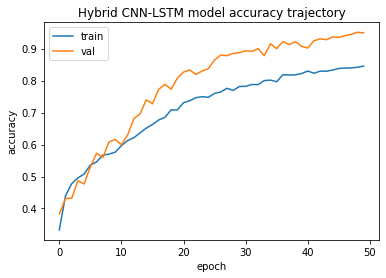

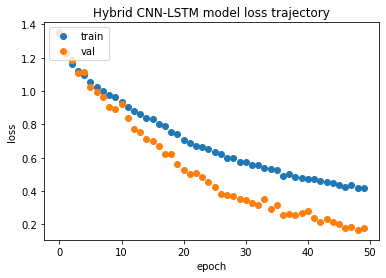

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_v7_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_v7_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_v7_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_v7_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
hybrid_cnn_lstm_model_v7_score = hybrid_cnn_lstm_model_v7.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_model_v7_score[1])



with open('cnn_lstm_bidirectional_lstm_layer_with_20_units.pickle', 'wb') as files:
    pickle.dump(hybrid_cnn_lstm_model_v7, files)

Test accuracy of the hybrid CNN-LSTM model: 0.6484198570251465
INFO:tensorflow:Assets written to: ram://19568000-0166-4fb7-b51b-70f68edbb9cb/assets


INFO:tensorflow:Assets written to: ram://19568000-0166-4fb7-b51b-70f68edbb9cb/assets


In [ ]:
hybrid_cnn_lstm_model_v8 = hybrid_cnn_lstm_units_change(20)
hybrid_cnn_lstm_model_v8.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_v8_results = hybrid_cnn_lstm_model_v8.fit(x_train,
             y_train,
             batch_size=100,
             epochs=60,
             validation_data=(x_valid, y_valid), verbose=True)





Epoch 1/60
70/70 [==============================] - 29s 358ms/step - loss: 1.3733 - accuracy: 0.2888 - val_loss: 1.3961 - val_accuracy: 0.3080
Epoch 2/60
70/70 [==============================] - 23s 325ms/step - loss: 1.2972 - accuracy: 0.3816 - val_loss: 1.3475 - val_accuracy: 0.3700
Epoch 3/60
70/70 [==============================] - 23s 336ms/step - loss: 1.2083 - accuracy: 0.4547 - val_loss: 1.2028 - val_accuracy: 0.4433
Epoch 4/60
70/70 [==============================] - 23s 322ms/step - loss: 1.1570 - accuracy: 0.4659 - val_loss: 1.1240 - val_accuracy: 0.4860
Epoch 5/60
70/70 [==============================] - 23s 325ms/step - loss: 1.1169 - accuracy: 0.5020 - val_loss: 1.0839 - val_accuracy: 0.5140
Epoch 6/60
70/70 [==============================] - 23s 330ms/step - loss: 1.0780 - accuracy: 0.5184 - val_loss: 1.0769 - val_accuracy: 0.5153
Epoch 7/60
70/70 [==============================] - 23s 334ms/step - loss: 1.0522 - accuracy: 0.5358 - val_loss: 1.0138 - val_accuracy: 0.5333

In [ ]:
hybrid_cnn_lstm_model_v8_score = hybrid_cnn_lstm_model_v8.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_model_v8_score[1])



with open('cnn_lstm_layer_with_20_units_epochs_60_batch_size_100.pickle', 'wb') as files:
    pickle.dump(hybrid_cnn_lstm_model_v8, files)

Test accuracy of the hybrid CNN-LSTM model: 0.68792325258255
INFO:tensorflow:Assets written to: ram://096b4052-c4d4-40bb-ba83-433a7cd43a8c/assets


INFO:tensorflow:Assets written to: ram://096b4052-c4d4-40bb-ba83-433a7cd43a8c/assets


EVALUATING CNN MODEL PERFORMANCE ACROSS TIME STEPS


In [ ]:
X_test = np.load("/content/drive/MyDrive/project_eeg/X_test.npy")
y_test = np.load("/content/drive/MyDrive/project_eeg/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/project_eeg/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/project_eeg/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/project_eeg/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/project_eeg/person_test.npy")
X_train_valid = X_train_valid[:, :22, :]
X_test = X_test[:, :22, :]
y_train_valid = to_categorical(y_train_valid - 769)
y_test = to_categorical(y_test - 769)

def cnn_model_upto_450(time_period=450):
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(1, 5), strides = 1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(22, time_period, 1), data_format='channels_last'))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(32, kernel_size=(1, 5), strides = 1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, kernel_size=(1, 5),strides = 1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate =0.001, epsilon=1e-8, decay=0.01), metrics=[categorical_accuracy])
    
  return model


def cnn_model_above_450(time_period=1000):
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), input_shape=(22, time_period, 1), data_format='channels_last'))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 4)))
  model.add(Dropout(0.2))
  model.add(Conv2D(32, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 4)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, kernel_size=(1, 10), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 4)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, kernel_size=(21, 1), strides=1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01)))
  model.add(ELU())
  model.add(BatchNormalization(axis=1))
  model.add(MaxPool2D((1, 4)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, epsilon=1e-8, decay=0.01), metrics=[categorical_accuracy])
  
  return model


def evaluate_cnn_across_time_steps(sub_idx=None, time_period=500):
  X_train_valid_current = X_train_valid[:, :, :time_period]
  y_train_valid_current = y_train_valid
  X_test_current = X_test[:, :, :time_period]
  y_test_current = y_test

  # preprocess data
  X_train_valid_current= np.expand_dims(X_train_valid_current, axis=3)
  X_test_current = np.expand_dims(X_test_current, axis=3)
  lecun = lecun_uniform(seed=42)
  
  if time_period < 450:
    model = cnn_model_upto_450(time_period)
  else:
    model = cnn_model_above_450(time_period)

  model.fit(X_train_valid_current, y_train_valid_current, epochs=40, batch_size=32, validation_data=(X_test_current, y_test_current), shuffle=True, verbose=1)
  train_score = model.evaluate(X_train_valid_current, y_train_valid_current)
  test_score = model.evaluate(X_test_current, y_test_current)

  print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
  print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
  print(model.summary())
    
  return train_score, test_score
    

    

In [ ]:
train_scores = []
test_scores = []

for time in range(100, 1001, 100):
    print("=================" + str(time) + "===================")
    train_score, test_score = evaluate_cnn_across_time_steps(time_period=time)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])

print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)
max_idx = np.argmax(test_scores)
print("The best accuracy is %.3f." %max(test_scores))
print("The corresponding time period is %d." %(100 + 100 * max_idx))

plt.plot(range(100, 1001, 100), train_scores, label='train accuracies')
plt.plot(range(100, 1001, 100), test_scores, label='test accuracies')
plt.legend()
plt.title("CNN Classification Accuracies across Time Steps")
plt.savefig('cnn_performance_across_time_steps.png', bbox_inches='tight')
plt.show()

=================100===================
Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/67 [==============================] - 14s 201ms/step - loss: 2.9923 - categorical_accuracy: 0.3210 - val_loss: 2.3809 - val_categorical_accuracy: 0.3725
Epoch 2/40
67/67 [==============================] - 13s 201ms/step - loss: 2.3632 - categorical_accuracy: 0.3939 - val_loss: 2.1739 - val_categorical_accuracy: 0.3950
Epoch 3/40
67/67 [==============================] - 13s 198ms/step - loss: 2.1564 - categorical_accuracy: 0.4251 - val_loss: 2.2522 - val_categorical_accuracy: 0.3634
Epoch 4/40
67/67 [==============================] - 13s 196ms/step - loss: 2.1046 - categorical_accuracy: 0.4312 - val_loss: 1.9912 - val_categorical_accuracy: 0.3815
Epoch 5/40
67/67 [==============================] - 13s 196ms/step - loss: 2.0029 - categorical_accuracy: 0.4482 - val_loss: 1.9367 - val_categorical_accuracy: 0.4334
Epoch 6/40
67/67 [==============================] - 13s 197ms/step - loss: 1.9152 - categorical_accuracy: 0.4780 - val_loss: 1.8930 - val_categorical_accuracy: 0.4515
Epoch 7/4

CNN-LSTM model with change in  learning rate 

In [ ]:
def hybrid_cnn_lstm_lr_change():
  # Building the CNN model using sequential class
  hybrid_cnn_lstm_model = Sequential()

  # Conv. block 1
  hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 2
  hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 3
  hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 4
  hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # FC+LSTM layers
  hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
  hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
  hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
  hybrid_cnn_lstm_model.add(LSTM(20, dropout=0.6, recurrent_dropout= 0.1, input_shape=(100,1), return_sequences=False))

  hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


  return hybrid_cnn_lstm_model

In [ ]:
# Model parameters
learning_rate = 5 * 1e-4
epochs = 50
hybrid_cnn_lstm_optimizer = Adam(learning_rate=learning_rate)

In [ ]:
hybrid_cnn_lstm_model_with_lr_change = hybrid_cnn_lstm_lr_change()
hybrid_cnn_lstm_model_with_lr_change.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_with_lr_change_results = hybrid_cnn_lstm_model_with_lr_change.fit(x_train,
             y_train,
             batch_size=64,
             epochs=50,
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/50
109/109 [==============================] - 54s 460ms/step - loss: 1.3625 - accuracy: 0.3057 - val_loss: 1.3179 - val_accuracy: 0.3513
Epoch 2/50
109/109 [==============================] - 49s 448ms/step - loss: 1.2852 - accuracy: 0.3938 - val_loss: 1.2382 - val_accuracy: 0.4273
Epoch 3/50
109/109 [==============================] - 49s 446ms/step - loss: 1.2421 - accuracy: 0.4286 - val_loss: 1.1700 - val_accuracy: 0.4707
Epoch 4/50
109/109 [==============================] - 48s 445ms/step - loss: 1.2007 - accuracy: 0.4519 - val_loss: 1.1901 - val_accuracy: 0.4600
Epoch 5/50
109/109 [==============================] - 48s 443ms/step - loss: 1.1752 - accuracy: 0.4688 - val_loss: 1.1246 - val_accuracy: 0.4940
Epoch 6/50
109/109 [==============================] - 48s 441ms/step - loss: 1.1551 - accuracy: 0.4846 - val_loss: 1.0815 - val_accuracy: 0.5207
Epoch 7/50
109/109 [==============================] - 48s 440ms/step - loss: 1.1312 - accuracy: 0.4889 - val_loss: 1.0814 - val_ac

In [ ]:
hybrid_cnn_lstm_model_with_lr_change

hybrid_cnn_lstm_model_with_lr_change_score = hybrid_cnn_lstm_model_with_lr_change.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_model_with_lr_change_score[1])


import pickle

with open('cnn_lstm_model_with_lr_5_x_e_-4', 'wb') as files:
    pickle.dump(hybrid_cnn_lstm_model_with_lr_change, files)

Test accuracy of the hybrid CNN-LSTM model: 0.7065462470054626
INFO:tensorflow:Assets written to: ram://24700941-9395-446a-b1bb-8abacbb0c760/assets


In [ ]:
%cd /content/drive/MyDrive/project_eeg/latest_model_runs/

/content/drive/MyDrive/project_eeg/latest_model_runs


In [ ]:
with open('cnn_lstm_model_with_lr_5_x_e_-4_acc_70_65.pickle', 'wb') as files:
    pickle.dump(hybrid_cnn_lstm_model_with_lr_change, files)

INFO:tensorflow:Assets written to: ram://ddd46ffd-367d-4765-a119-fa90f5472511/assets


INFO:tensorflow:Assets written to: ram://ddd46ffd-367d-4765-a119-fa90f5472511/assets


Training the CNN-LSTM model on individual subject and testing it across all subjects (including self) and generatig a matrix[sub_train_idx][sub_test_idx] = test_accuracy for model trained and validated on sub_train_idx and tested on sub_test_idx

In [ ]:
def max_vote(model, X, y, n_augmented=4):
    y_pred = model.predict(X)
    N = np.shape(X)[0]
    count = 0
    for i in range(N//n_augmented):
        pred = np.zeros(n_augmented)
        for j in range(n_augmented):
          pred[np.argmax(y_pred[i + (N//n_augmented)*j])] += 1
        if np.argmax(pred) == np.argmax(y[i]): count+=1
    accuracy = count/(N//n_augmented)
    return accuracy

In [ ]:
def train_and_evaluate(model, sub_train_idx, sub_test_idx):
  

  """

  Training and validating the model (CNN + LSTM : epochs - 50, batch_size - 64, learning rate - 5 * 10 ^(-4) , optimizer - Adam, lstm_units -20 ) 
  on the sub_train_idx 
  and Testing / Evaluating the trained model on sub_test_idx

  This function returns the test_accuracy for the model trained on sub_train_idx and evaluated on sub_test_idx (sub_test_idx can be equal to sub_train_idx)

  returns (test_acc)

  """
  # loading the train_val_set for sub_train_idx

  X_train_valid_sub_train = np.load("/content/drive/MyDrive/project_eeg/subjects/X_train_valid_sub" + str(sub_train_idx) + ".npy")
  y_train_valid_sub_train = np.load("/content/drive/MyDrive/project_eeg/subjects/y_train_valid_sub" + str(sub_train_idx) + ".npy")

  # loading the test set for sub_test_idx 
  X_test_sub_test = np.load("/content/drive/MyDrive/project_eeg/subjects/X_test_sub" + str(sub_test_idx) + ".npy")
  y_test_sub_test  = np.load("/content/drive/MyDrive/project_eeg/subjects/y_test_sub" + str(sub_test_idx) + ".npy")
  
  
  y_test_sub_test -= 769
  y_train_valid_sub_train -=769

  ## Preprocessing the dataset 

  X_train_valid_prep_sub_train,y_train_valid_prep_sub_train = data_prep(X_train_valid_sub_train,y_train_valid_sub_train,2,2,True)
    
  X_test_prep_sub_test,y_test_prep_sub_test = data_prep(X_test_sub_test,y_test_sub_test,2,2,True)

  ## Random splitting and reshaping the data

  # First generating the training and validation indices using random splitting
  ind_valid = np.random.choice(X_train_valid_prep_sub_train.shape[0], int(0.2 * X_train_valid_prep_sub_train.shape[0]) , replace=False)
  ind_train = np.array(list(set(range(X_train_valid_prep_sub_train.shape[0])).difference(set(ind_valid))))

  # Creating the training and validation sets using the generated indices
  (x_train, x_valid) = X_train_valid_prep_sub_train[ind_train], X_train_valid_prep_sub_train[ind_valid] 
  (y_train, y_valid) = y_train_valid_prep_sub_train[ind_train], y_train_valid_prep_sub_train[ind_valid]

  # Converting the labels to categorical variables for multiclass classification
  y_train = to_categorical(y_train, 4)
  y_valid = to_categorical(y_valid, 4)
  y_test = to_categorical(y_test_prep_sub_test, 4)

  # Adding width of the segment to be 1
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
  x_test =X_test_prep_sub_test.reshape(X_test_prep_sub_test.shape[0], X_test_prep_sub_test.shape[1], X_test_prep_sub_test.shape[2], 1)


  # Reshaping the training and validation dataset
  x_train = np.swapaxes(x_train, 1,3)
  x_train = np.swapaxes(x_train, 1,2)
  x_valid = np.swapaxes(x_valid, 1,3)
  x_valid = np.swapaxes(x_valid, 1,2)
  x_test = np.swapaxes(x_test, 1,3)
  x_test = np.swapaxes(x_test, 1,2)

  model = model

  model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

  # Training and validating the model on sub_train_idx
  model_results =model.fit(x_train,
              y_train,
              batch_size=64,
              epochs=50,
              validation_data=(x_valid, y_valid), verbose=True)
  
  # Evaluating the trained model (trained on sub_train_idx) on sub_test

  model_score = model.evaluate(x_test, y_test, verbose=0)
  print(f'Test accuracy of model_trained_on_{sub_train_idx} and evaluated on {sub_test_idx}:',model_score[1])

  

  return max_vote(model, x_test, y_test)


  




      

In [ ]:

# Model parameters
learning_rate = 5 * 1e-4
epochs = 50
hybrid_cnn_lstm_optimizer = Adam(learning_rate=learning_rate)

# model

def cnn_lstm_best():
  # Building the CNN model using sequential class
  hybrid_cnn_lstm_model = Sequential()

  # Conv. block 1
  hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 2
  hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 3
  hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 4
  hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # FC+LSTM layers
  hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
  hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
  hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
  hybrid_cnn_lstm_model.add(LSTM(20, dropout=0.6, recurrent_dropout= 0.1, input_shape=(100,1), return_sequences=False))

  hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


  return hybrid_cnn_lstm_model





matrix =  [ [ 0 for i in range(9) ] for j in range(9) ]


# calling the train_and_evaluate function and filling up the matrix 
for sub_train_idx in range(9):
  for sub_test_idx in range(9):
    model = cnn_lstm_best()
    matrix[sub_train_idx][sub_test_idx] = train_and_evaluate(model, sub_train_idx, sub_test_idx)



Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 4s 317ms/step - loss: 0.4012 - accuracy: 0.8625 - val_loss: 0.3087 - val_accuracy: 0.9198
Epoch 36/50
12/12 [==============================] - 4s 316ms/step - loss: 0.4004 - accuracy: 0.8665 - val_loss: 0.2696 - val_accuracy: 0.9251
Epoch 37/50
12/12 [==============================] - 4s 320ms/step - loss: 0.3486 - accuracy: 0.8879 - val_loss: 0.2533 - val_accuracy: 0.9358
Epoch 38/50
12/12 [==============================] - 4s 317ms/step - loss: 0.3701 - accuracy: 0.8838 - val_loss: 0.2664 - val_accuracy: 0.9251
Epoch 39/50
12/12 [==============================] - 4s 317ms/step - loss: 0.3818 - accuracy: 0.8745 - val_loss: 0.2927 - val_accuracy: 0.8984
Epoch 40/50
12/12 [==============================] - 4s 318ms/step - loss: 0.3511 - accuracy: 0.8879 - val_loss: 0.3138 - val_accuracy: 0.9091
Epoch 41/50
12/12 [==============================] - 4s 321ms/step - loss: 0.3212 - accuracy: 0.8999 - 

In [ ]:
train_and_evaluate(model,0, 1)


In [ ]:
train_and_evaluate(model,0, 0)

In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 50
hybrid_cnn_lstm_optimizer = Adam(learning_rate=learning_rate)

In [ ]:
import tensorflow as tf

def scheduler(epoch, lr): # keeping learning rate constant for first 10 epochs and then decaying them
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)


callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks=[callback] # add in model.fit 